# Introduction

* This notebook aims to use a simple LTSpice simulation of a series RLC circuit;
* The input voltage signals are generated using numpy;
* The PyLTSpice package is used to control and process the data from the simulation.

### Generating base signals 

In [293]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from quantiphy import Quantity #to format numbers 

### Generating the sinc function in time domain
* Given a bandwidth and a sampling rate, create a sinc pulse  $p(t)$ in the time domain;
* This pulse will be used to modulate a data given a certain modulation scheme.

The equation of the sinc function is:

$p(t) =  sinc \left ( 2Bt \right )$

Where:
- B is the bandwidth in Hz;
- $sinc$ in numpy refers to $sinc(t) = \frac{\sin(\pi t) }{ \pi t}$

In the frequecy domain, the sinc signal $p(t)$ transforms into as a rectangular spectrum, defined by the following equation:

$\chi \{ p(t) \} = rect \left ( \dfrac{\omega}{2B} \right ) $

Where:
* $\chi \{ \}$ stands for the Fourier Transform operation;
* $rect$ stands for the rectangular pulse function.

The $rect$ function is described by the following expression:

$rect \left ( \dfrac{\omega}{B}\right ) =  \begin{cases}1 & -B/2 \geq \omega \geq B/2 \\
0 & \mathrm{otherwise} \\
\end{cases}$



In [305]:
#initial parameters
t_init = 0 #initial time array
t_end = 1e-3 #end of time array
numPoints = 100 #points per pulse
t_step = t_end/numPoints #time step
f_sampling = 1/t_step #equivalent sampling frequency
bw_Hz = 50e3 #bandwidth of signal in Hz 

bw_Hz = 50e3 #bandwidth of pulse signal in Hz
k = 10  #upsampling factor
f_sampling = k*bw_Hz #sampling frequency
t_step = 1/f_sampling
t_init = 0
numPoints = round(f_sampling/bw_Hz) #points per pulse
t_end = numPoints*t_step

#time vector
time = np.linspace(t_init,t_end,numPoints)
t_disp = time.item(round(numPoints/2)) #time displacement of sinc pulse


print("BASIC TIME DATA FOR SINC PULSE")
print("Time step:")
print(Quantity(t_step,'s'))
print("Sampling Frequency: ")
print(Quantity(f_sampling,'Hz'))
print("Length of time vector:")
print(time.size)
print("Length of pulse (in s):")
print(Quantity(t_end,'s'))
print("Bandwidth of signal:")
print(Quantity(bw_Hz,'Hz'))
print("Sampling Frequency / Bandwidth factor:")
print(f_sampling/bw_Hz)
print("Time displacement:")
print(Quantity(t_disp,'s'))

BASIC TIME DATA FOR SINC PULSE
Time step:
2 us
Sampling Frequency: 
500 kHz
Length of time vector:
10
Lenght of pulse (in s):
20 us
Bandwidth of signal:
50 kHz
Sampling Frequency / Bandwidth factor:
10.0
Time displacement:
11.111 us


### Plot of sinc pulse in time domain

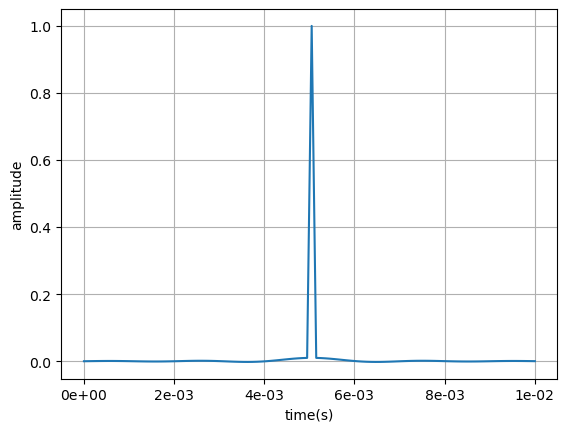

In [295]:
vsinc = np.sinc((2*bw_Hz)*(time-t_disp))

plt.plot(time,vsinc)
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.grid()

### FFT Parameters 

In [296]:
#parameters for FFT
count = len(vsinc)
values = np.arange(int(count/2))
time_period = count/f_sampling
frequencies = values/time_period

print("FFT PARAMETERS")
print("Length of sinal (must be the equals numPoints):")
print(count)
print("Sample of the frequency components:")
print(values[:10])
print("FFT time window length:")
print(Quantity(time_period,'s'))
print("Sample of the array of frequencies (Hz):")
print(frequencies[:10])
print("Length of frequencies array:")
print(len(frequencies))

FFT PARAMETERS
Length of sinal (must be the equals numPoints):
100
Sample of the frequency components:
[0 1 2 3 4 5 6 7 8 9]
FFT time window length:
10 ms
Sample of the array of frequencies (Hz):
[  0. 100. 200. 300. 400. 500. 600. 700. 800. 900.]
Length of frequencies array:
50


### FFT Plot of sinc pulse

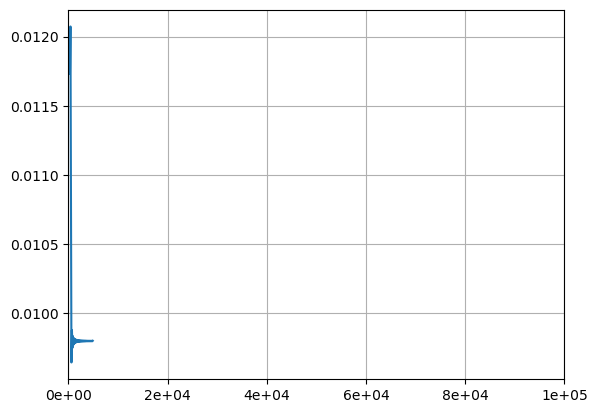

In [297]:
vsinc_fft = np.fft.fft(vsinc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
frequencies = np.fft.fftfreq(vsinc.size,1/f_sampling) #gets the vector of positive frequencies

plt.plot(frequencies[:int(frequencies.size/2)],abs(vsinc_fft[:int(frequencies.size/2)])**2) #plots power spectrum
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.grid()

### Root-raised cosine pulse (RRC)

Generally speaking, the RRC pulse $h(t)$ is a sinc filter multiplied by an attenuation factor in the form:

$ h(t) = sinc(2Bt) \cos(\pi t r B) \dfrac{\cos(\pi t r B)}{1 - 4 r^2 t^2 B^2}$

Where:
* $r$ is the roll-of factor that controls the ripple of the spectrum lobe, also its rate of decay;
* $B$ is the bandwidth of the signal
* $t$ is the time array

GridSpec(1, 1)

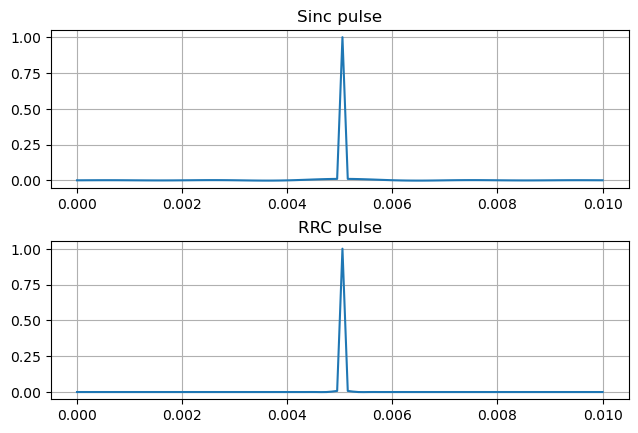

In [298]:
#roll-of factor 
r = 0.1
#rrc filter on time domain
h_rrc = vsinc * (np.cos(np.pi*(time-t_disp)*r*bw_Hz)) / (1 - 4 * r**2 * (time-t_disp)**2 * bw_Hz**2)

##ploting both filters
fig, axs = plt.subplots(2)
axs[0].plot(time,vsinc)
axs[0].set_title("Sinc pulse")
axs[0].grid()
axs[1].plot(time,h_rrc)
axs[1].set_title("RRC pulse")
axs[1].grid()

# shift subplots down to adjust titles
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.add_gridspec()


### FFT of RRC pulse


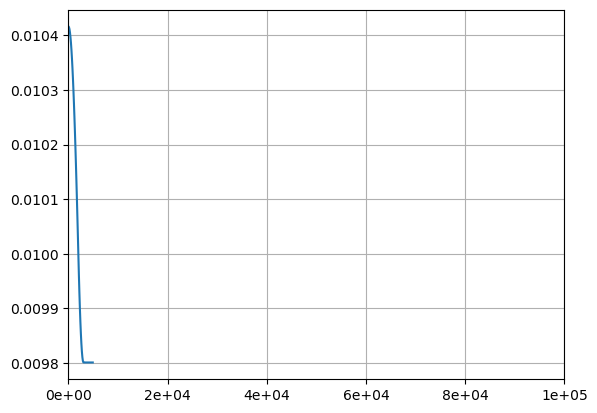

In [299]:
h_rrc_fft = np.fft.fft(h_rrc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
frequencies = np.fft.fftfreq(h_rrc.size,1/f_sampling) #gets the vector of positive frequencies

plt.plot(frequencies[:int(frequencies.size/2)],abs(h_rrc_fft[:int(frequencies.size/2)])**2) #plots power spectrum
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.grid()

### Comparison between spectrums

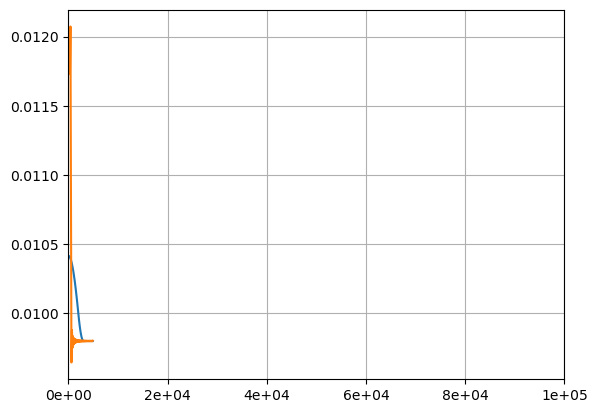

In [300]:
plt.plot(frequencies[:int(frequencies.size/2)],abs(h_rrc_fft[:int(frequencies.size/2)])**2) #power spectrum rcc pulse
plt.plot(frequencies[:int(frequencies.size/2)],abs(vsinc_fft[:int(frequencies.size/2)])**2) #power spectrum sinc pulse
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*bw_Hz]) #defines frequency limit
plt.grid() #grid on

## Generating pulse train data 


* With the pulses provided, generate a pulse train data of BPSK modulation